In [1]:
from heron.models.georgebased import HodlrReducedGPR, DATA_PATH
from heron.models import ReducedModel
import os.path
import numpy as np
import george
from elk.waveform import Timeseries

In [46]:
class KNReduced(HodlrReducedGPR):
    """Produce KN lightcurves in a reduced basis."""
    strain_input_factor = 1
    def __init__(self):
        """Create a reduced-order Gaussian process surrogate for binary black hole waveforms 
        using a basis constructed using ``IMRPhenomPv2``.

        This model loads the `test_basis` from the model data directory.
        """
        basis_data = "new_kn_basis.json" #os.path.join(DATA_PATH, "new_kn_basis.json")
        # extract the basis information
        super().__init__()
        super(HodlrReducedGPR, self).__init__(basis_data)
        self.training_x = self.locs
        self.training_y = np.nan_to_num(self.coeffs).T
        self.y_err = np.ones_like(self.training_y)*1e-4
        
        self.kernels = [george.kernels.ExpSquaredKernel([.1]*self.training_x.shape[1], ndim=self.training_x.shape[1]) 
                        for dim in range(self.training_y.shape[1])]
                
        self.gps =  [george.GP(self.kernels[dim], mean = 0) for dim in range(self.training_y.shape[1])]
        
        self._compute()
    
    def _compute(self):
        for i, gp in enumerate(self.gps):
            gp.compute(self.training_x, self.y_err[:,i])
    
    def _predict_coefficients(self, p):
        """Calculate the coefficients for a given location in parameter space."""
        coeffs = []
        p = np.atleast_2d(p)
        for i, gp in enumerate(self.gps):
            coeffs.append(gp.predict(self.training_y[:,i], p))
        coeffs = np.array(coeffs).squeeze()
        return coeffs

    def mean(self, p):
        """Returns the mean timeseries"""
        coefficients = self._predict_coefficients(p)
        mean = self.basis.T.dot(coefficients[:,0]/self.strain_input_factor)

        return Timeseries(data=mean, times=self.abscissa/self.time_factor)

In [47]:
kn = KNReduced()

In [48]:
ts = kn.mean(kn.training_x[10])

(-25, 25)

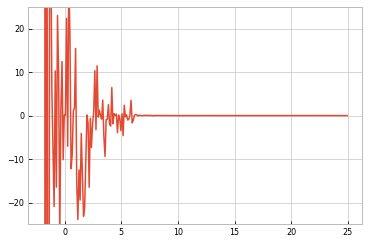

In [49]:
plt.plot(ts.times, ts.data)
plt.ylim(-25,25)

In [16]:
import matplotlib.pyplot as plt

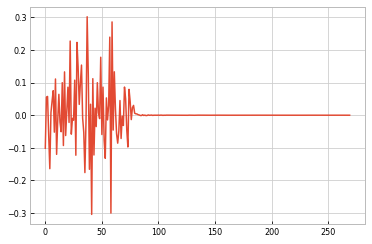

In [55]:
plt.plot(kn.basis[100])